# BOVW模型的处理过程：

1. SIFT特征提取。SIFT 特征提取是求出图像的关键点信息，包括角度，大小以及强度。关键点，也就是能够代表图像关键信息的部分，这也是Bag of words中单词的组成。一个图像通常有很多的关键点。

2. 聚类。我们将每幅图像中的关键点信息添加到词袋中，并定义聚类中心的数量N。然后将词袋中的关键点通过Kmeans算法聚类到N个类中。同时得到这N个类的中心点组成N*128的dictionary，每个中心都可以代表这个类。

3. 求图像的直方图。将图像的关键点信息重新放到词包中，根据落在每个类中关键点的数量来得到图像的直方图，大小为1*N。将每幅图像进行处理，得到图像在BOW模型下的特征。

4. 图像匹配。将测试图像进行相同的处理，同样也得到1*N的特征。根据测试图像与训练图像特征之间的距离，并将距离较小的图像作为检索的结果。



# データ確認（KIMIA_Path_20クラス*48枚=960）

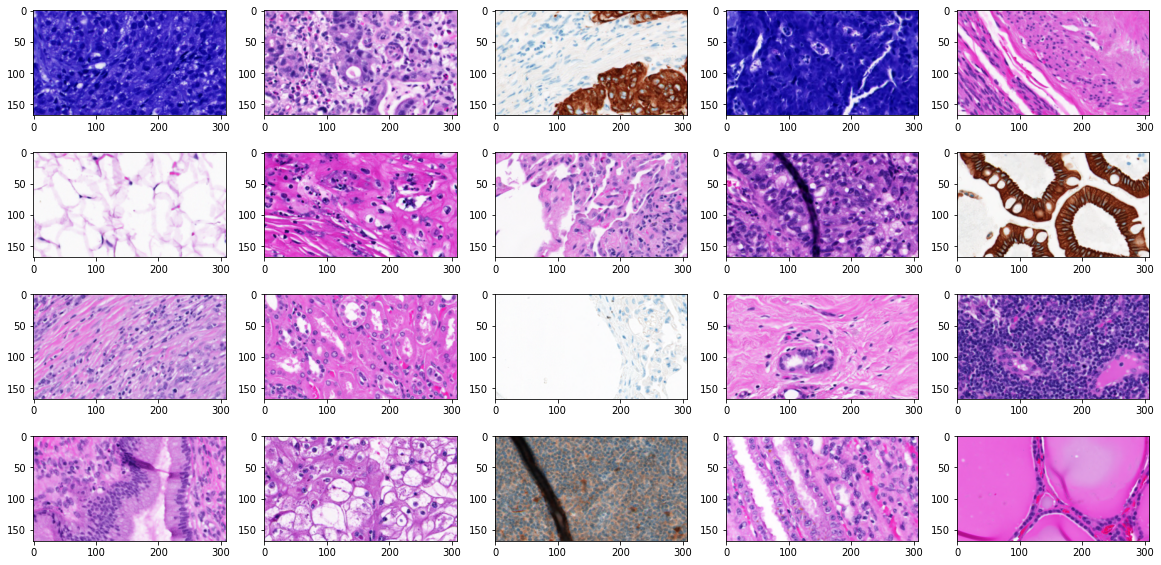

In [7]:
import cv2,os
import numpy as np
from matplotlib import pyplot as plt

load = "../Database/KIMIA_Path_960/train/"
classes = ["A","B","C","D","E","F","G","H","I","J","K","L","M","N","O","P","Q","R","S","T"]

fig, ax = plt.subplots(2,2, figsize = (20,10))
for n in range(20):
    img = cv2.imread(load+classes[n]+"10.tif")
    plt.subplot(4,5,n+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# データの読み込み

In [22]:
load = "../Database/KIMIA_Path_960/train"
all_files=[]
file_label=[]

for root,dirs,files in os.walk(load):
    for file_name in files:
        file = os.path.join(root,file_name)
        label = os.path.join(file_name)
        all_files.append(file)
        file_label.append(label[0])
all_files.remove("../Database/KIMIA_Path_960/train/.DS_Store")
file_label.remove(".")
print(len(all_files))
print(len(file_label))

960
960


# 特徴点の抽出

In [23]:
k = 20
detector = cv2.xfeatures2d.SIFT_create()
trainer = cv2.BOWKMeansTrainer(k)
keypoints = []
directors = []
for file in all_files:
    image = cv2.imread(file)
    ks, ds = detector.detectAndCompute(image, None)
    trainer.add(ds.astype(np.float32))
    keypoints.append(ks)
    directors.append(ds)
print("keypoints: ",len(keypoints))

keypoints:  960


In [24]:
len(directors[1][1])

128

# クラスタリング

In [25]:
dictionary = trainer.cluster()
print("dictionary: ",dictionary.shape)

dictionary:  (20, 128)


In [26]:
len(dictionary[1])

128

# 提言する表現方法

In [7]:
import math

def eculidDisSim(x,y):
    '''
    欧几里得相似度计算方法
    '''
    return math.sqrt(sum(pow(a-b,2) for a,b in zip(x,y)))

def cosSim(x,y):
    '''
    余弦相似度计算方法
    '''
    tmp=sum(a*b for a,b in zip(x,y))
    non=np.linalg.norm(x)*np.linalg.norm(y)
    return round(tmp/float(non),3)


In [8]:
cat = []
hist = []
dis = []
cos = []
for i in range(20):
    cat.append([])
    hist.append(0)
    dis.append([])
    cos.append([])

print(cos)

[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]


In [9]:
len(directors[1])

1000

In [10]:
for point in directors[1]:
    point_dis = 999999999
    for i in range(len(dictionary)):
        if point_dis > eculidDisSim(point, dictionary[i]):
            point_dis = eculidDisSim(point, dictionary[i])
            point_cat = i
    cat[point_cat].append(point)
    dis[point_cat].append(point_dis)
    hist[point_cat] += 1
    cos[point_cat].append(cosSim(point, dictionary[point_cat]))

In [11]:
descriptor = []
for i in range(len(dictionary)):
    descriptor.append(hist[i]/len(directors[1]))
    descriptor.append(np.mean(dis[i])/1000)
    descriptor.append(np.mean(cos[i]))

print(descriptor)

[0.047, 0.3430272330035709, 0.7392765957446809, 0.032, 0.3343374081434289, 0.75465625, 0.028, 0.33055352318821574, 0.7630000000000001, 0.023, 0.3420443893920013, 0.741304347826087, 0.031, 0.33939659613953754, 0.7457741935483869, 0.035, 0.33133003777382536, 0.760257142857143, 0.038, 0.33474953851932165, 0.7541052631578948, 0.035, 0.34666667276498, 0.7325714285714285, 0.179, 0.26982750195627475, 0.847268156424581, 0.041, 0.301425041773331, 0.8056585365853659, 0.046, 0.339506090216603, 0.7469782608695652, 0.058, 0.33795132561339436, 0.7486896551724138, 0.083, 0.30153915220196376, 0.8044096385542169, 0.048, 0.3370577012686809, 0.7508333333333334, 0.025, 0.3146383118645011, 0.7878400000000001, 0.062, 0.34106486505767325, 0.7439516129032258, 0.026, 0.3270896823801125, 0.7678076923076923, 0.044, 0.3311803399403458, 0.7601136363636364, 0.042, 0.3318887094711031, 0.7587380952380952, 0.077, 0.33015570407558037, 0.7617662337662336]


In [12]:
from tqdm import trange
import time

In [13]:
def descriptor_new(IMG):
    image = cv2.imread(IMG)
    ks, ds = detector.detectAndCompute(image, None)
    cat = []
    hist = []
    dis = []
    cos = []
    for i in range(20):
        cat.append([])
        hist.append(0)
        dis.append([])
        cos.append([])

    for point in ds:
        point_dis = 999999999
        for i in range(len(dictionary)):
            if point_dis > eculidDisSim(point, dictionary[i]):
                point_dis = eculidDisSim(point, dictionary[i])
                point_cat = i
        cat[point_cat].append(point)
        dis[point_cat].append(point_dis)
        hist[point_cat] += 1
        cos[point_cat].append(cosSim(point, dictionary[point_cat]))

    descriptor = []
    for i in range(len(dictionary)):
        descriptor.append(hist[i]/len(ds))
        descriptor.append(np.mean(dis[i])/1000.0)
        descriptor.append(np.mean(cos[i]))
        
    for i in range(0,60,3):
        descriptor[i] = descriptor[i]*10
    
    return descriptor

In [14]:
img = "../Database/KIMIA_Path_960/train/C24.tif"
new = descriptor_new(img)

suma=0
for i in range(0,60,3):
    suma+=new[i]
suma

9.999999999999998

In [15]:
all_descriptor = []

for n in trange(960):   
    cat = []
    hist = []
    dis = []
    cos = []
    for i in range(20):
        cat.append([])
        hist.append(0)
        dis.append([])
        cos.append([])

    for point in directors[n]:
        point_dis = 999999999
        for i in range(len(dictionary)):
            if point_dis > eculidDisSim(point, dictionary[i]):
                point_dis = eculidDisSim(point, dictionary[i])
                point_cat = i
        cat[point_cat].append(point)
        dis[point_cat].append(point_dis)
        hist[point_cat] += 1
        cos[point_cat].append(cosSim(point, dictionary[point_cat]))

    descriptor = []
    for i in range(len(dictionary)):
        descriptor.append(hist[i]/len(directors[n]))
        descriptor.append(np.mean(dis[i])/1000.0)
        descriptor.append(np.mean(cos[i]))
        
    all_descriptor.append(descriptor)


  1%|▏         | 12/960 [01:44<2:07:57,  8.10s/it]/Users/Alpaca/Library/Python/3.8/lib/python/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/Alpaca/Library/Python/3.8/lib/python/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 960/960 [2:09:11<00:00,  8.07s/it]  


In [18]:
all_descriptor = np.array(all_descriptor)

In [19]:
all_descriptor.shape

(960, 60)

In [20]:
np.save("all_descriptor.npy",all_descriptor)

In [21]:
all_descriptor[0]=all_descriptor[1]

In [22]:
# 出现回数合計＝10

for m in range(960):
    for i in range(0,60,3):
        all_descriptor[m][i] = all_descriptor[m][i]*10
#     des[np.isnan(des)]=0

In [23]:
suma=0

for m in range(1):
    for i in range(0,60,3):
#         all_descriptor[1][i] = all_descriptor[1][i]/10
        suma+=all_descriptor[m][i]
suma

9.999999999999998

In [24]:
# 出现回数合計＝１００

for m in range(960):
    for i in range(0,60,3):
        all_descriptor[m][i] = all_descriptor[m][i]/10

In [25]:
suma=0

for m in range(1):
    for i in range(0,60,3):
#         all_descriptor[1][i] = all_descriptor[1][i]/10
        suma+=all_descriptor[m][i]
suma

1.0000000000000002

In [26]:
all_descriptor[0]

array([0.047     , 0.34302723, 0.7392766 , 0.032     , 0.33433741,
       0.75465625, 0.028     , 0.33055352, 0.763     , 0.023     ,
       0.34204439, 0.74130435, 0.031     , 0.3393966 , 0.74577419,
       0.035     , 0.33133004, 0.76025714, 0.038     , 0.33474954,
       0.75410526, 0.035     , 0.34666667, 0.73257143, 0.179     ,
       0.2698275 , 0.84726816, 0.041     , 0.30142504, 0.80565854,
       0.046     , 0.33950609, 0.74697826, 0.058     , 0.33795133,
       0.74868966, 0.083     , 0.30153915, 0.80440964, 0.048     ,
       0.3370577 , 0.75083333, 0.025     , 0.31463831, 0.78784   ,
       0.062     , 0.34106487, 0.74395161, 0.026     , 0.32708968,
       0.76780769, 0.044     , 0.33118034, 0.76011364, 0.042     ,
       0.33188871, 0.7587381 , 0.077     , 0.3301557 , 0.76176623])

# ヒストグラム

In [27]:
matcher = cv2.BFMatcher()
extractor = cv2.BOWImgDescriptorExtractor(detector, matcher)
extractor.setVocabulary(dictionary)
descriptor_list = []
for file in all_files:
    image = cv2.imread(file)
    ks = detector.detect(image, None)
    descriptor = extractor.compute(image, ks)[0]
    descriptor_list.append(descriptor)

print("descriptor: ",type(descriptor))
print("descriptor: ",descriptor.shape)
print("descriptor_list: ",type(descriptor_list))
print("descriptor_list: ",len(descriptor_list))

descriptor:  <class 'numpy.ndarray'>
descriptor:  (20,)
descriptor_list:  <class 'list'>
descriptor_list:  960


# 提言した方法により、近似画像検索

In [31]:
def similar(img):
    descriptor = descriptor_new(img)
    matches = []
    for i in range(960): 
        matches.append(eculidDisSim(descriptor,all_descriptor[i]))
    simi_file = zip(matches, all_files)
    return sorted(simi_file)

>> 検索元画像


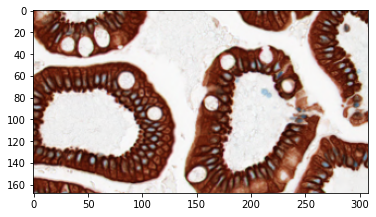

>> 検索結果


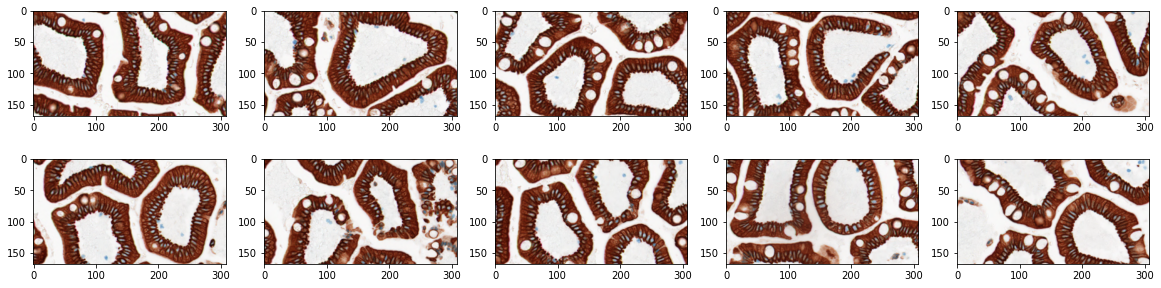

In [37]:
img = "../Database/KIMIA_Path_960/test/J48.tif"
print(">> 検索元画像")
img1 = cv2.imread(img)
plt.imshow(cv2.cvtColor(img1,cv2.COLOR_BGR2RGB))
plt.show()

simi_list = similar(img)
print(">> 検索結果")
fig, ax = plt.subplots(2,2, figsize = (20,10))
for i in range(20):
    img = cv2.imread(simi_list[i][1])
    plt.subplot(4,5,i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# BPNN画像分類

In [ ]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [23]:
descriptor_data = np.array(descriptor_list)
file_label_int = LabelEncoder().fit(file_label).transform(file_label)

X_train, X_test, y_train, y_test = train_test_split(descriptor_data, file_label_int, test_size=0.3, random_state=42)
print("Train: ",type(X_train),X_train.shape,type(y_train),y_train.shape,"\nTest: ",type(X_test),X_test.shape,type(y_test),y_test.shape)

Train:  <class 'numpy.ndarray'> (672, 20) <class 'numpy.ndarray'> (672,) 
Test:  <class 'numpy.ndarray'> (288, 20) <class 'numpy.ndarray'> (288,)


In [1]:
model = keras.Sequential([
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(20, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [2]:
model.fit(X_train, y_train, epochs=30)

In [4]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('\nTest accuracy:', test_acc)


Test accuracy: 0.933055820465088


# 画像類別予測

In [34]:
def classify(load, img):
    print(">>",img)
    image = cv2.imread(load+img)
    ks = detector.detect(image, None)
    descriptor = extractor.compute(image, ks)[0]
    prediction = model.predict(descriptor.reshape(1,-1))
    predict_label = classes[np.argmax(prediction)]
    print(">> This IMG's label is "+predict_label)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()
    print(">> CLASS"+predict_label+": 上皮細胞")
    

>> 上皮細胞.png
>> This IMG's label is B


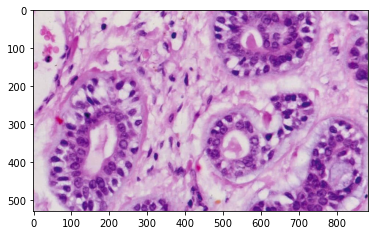

>> CLASSB: 上皮細胞


In [35]:
load = "../Database/KIMIA_Path_960/test/"
img = "上皮細胞.png"
classify(load, img)